# **Weather Dataset Preprocessing**

In [1]:
%load_ext autoreload
%autoreload 2


from datetime import datetime
import seaborn as sns

from utils import *

datasets_folder = './datasets'

2025-05-10 23:15:17.732266: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-10 23:15:17.820955: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-10 23:15:17.897407: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746944117.981108   87337 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746944118.015559   87337 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746944118.251590   87337 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

## **Data Reading**

We start by reading the dataset `csv` and performing some initial column renaming and preprocessing.

In [2]:
weather_folder = os.path.join(datasets_folder,'weather')

weather_df = merge_csv_to_dataframe(weather_folder).rename(columns={'PragaTime':'Date'})
weather_df['Date'] = pd.to_datetime(weather_df['Date'])
weather_df = weather_df.set_index('Date')
weather_df

Merged 6 CSV files


TAVG  PREC  RHAVG  RAD  W_SCAL_INT  W_VEC_DIR  W_VEC_INT  \
Date                                                                            
2021-01-01 00:00:00   4.7   0.3   87.0  0.0         1.8      322.3        1.8   
2021-01-01 01:00:00   4.2   0.1   87.1  0.0         0.9      339.6        0.8   
2021-01-01 02:00:00   4.3   0.0   88.1  0.0         0.5      249.0        0.5   
2021-01-01 03:00:00   4.2   0.6   90.8  0.0         0.9       68.7        0.4   
2021-01-01 04:00:00   4.1   0.1   90.4  0.0         1.2      160.4        0.9   
...                   ...   ...    ...  ...         ...        ...        ...   
2023-12-31 19:00:00  13.4   0.0   69.2  0.0         6.2      207.2        6.0   
2023-12-31 20:00:00   8.6   0.0   92.9  0.0         5.6      277.4        5.5   
2023-12-31 21:00:00   8.8   0.6   96.5  0.0         2.6      240.3        2.5   
2023-12-31 22:00:00  12.2   0.2   85.9  0.0         5.9      218.4        5.8   
2023-12-31 23:00:00  11.8   0.0   81.7  0.0         5.6      222.1        5.5   

                     LEAFW  ET0  
Date                             
2021-01-01 00:00:00    1.0  0.0  
2021-01-01 01:00:00    1.0  0.0  
2021-01-01 02:00:00    1.0  0.0  
2021-01-01 03:00:00    1.0  0.0  
2021-01-01 04:00:00    1.0  0.0  
...                    ...  ...  
2023-12-31 19:00:00    0.0  0.0  
2023-12-31 20:00:00    0.0  0.0  
2023-12-31 21:00:00    1.0  0.0  
2023-12-31 22:00:00    1.0  0.0  
2023-12-31 23:00:00    0.0  0.0  

[52585 rows x 9 columns]

The dataset contains the following informations:
- TAVG → Average Temperature
- PREC → Precipitation
- RHAVG → Average Relative Humidity
- RAD → Solar Radiation
- W_SCAL_INT → Scalar Wind Intensity
- W_VEC_DIR → Vector Wind Direction
- W_VEC_INT → Vector Wind Intensity
- LEAFW → Leaf Wetness
- ET0 → Evapotranspiration

We display a correlation matrix to inspect features that might be connected.

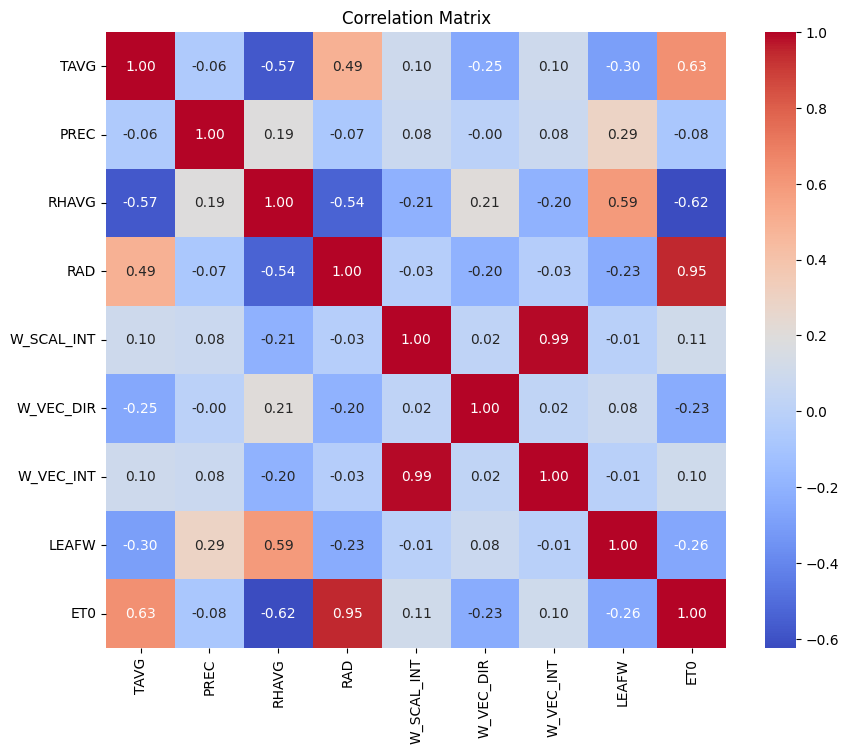

In [3]:
correlation_matrix = weather_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

W_VEC_INT is useless since that we have intensity and direction.

We also drop ET0 because it is highly correlated with RAD, and more than it w.r.t. the other features.

In [4]:
weather_df = weather_df.drop(columns=['W_VEC_INT','ET0'])


There are no missing values nor missing hours inbetween:

In [5]:
weather_df.resample('1h')
weather_df.isna().sum()

TAVG          0
PREC          0
RHAVG         0
RAD           0
W_SCAL_INT    0
W_VEC_DIR     0
LEAFW         0
dtype: int64

## **Data Visualization**

Let's check the behavior of the weather features

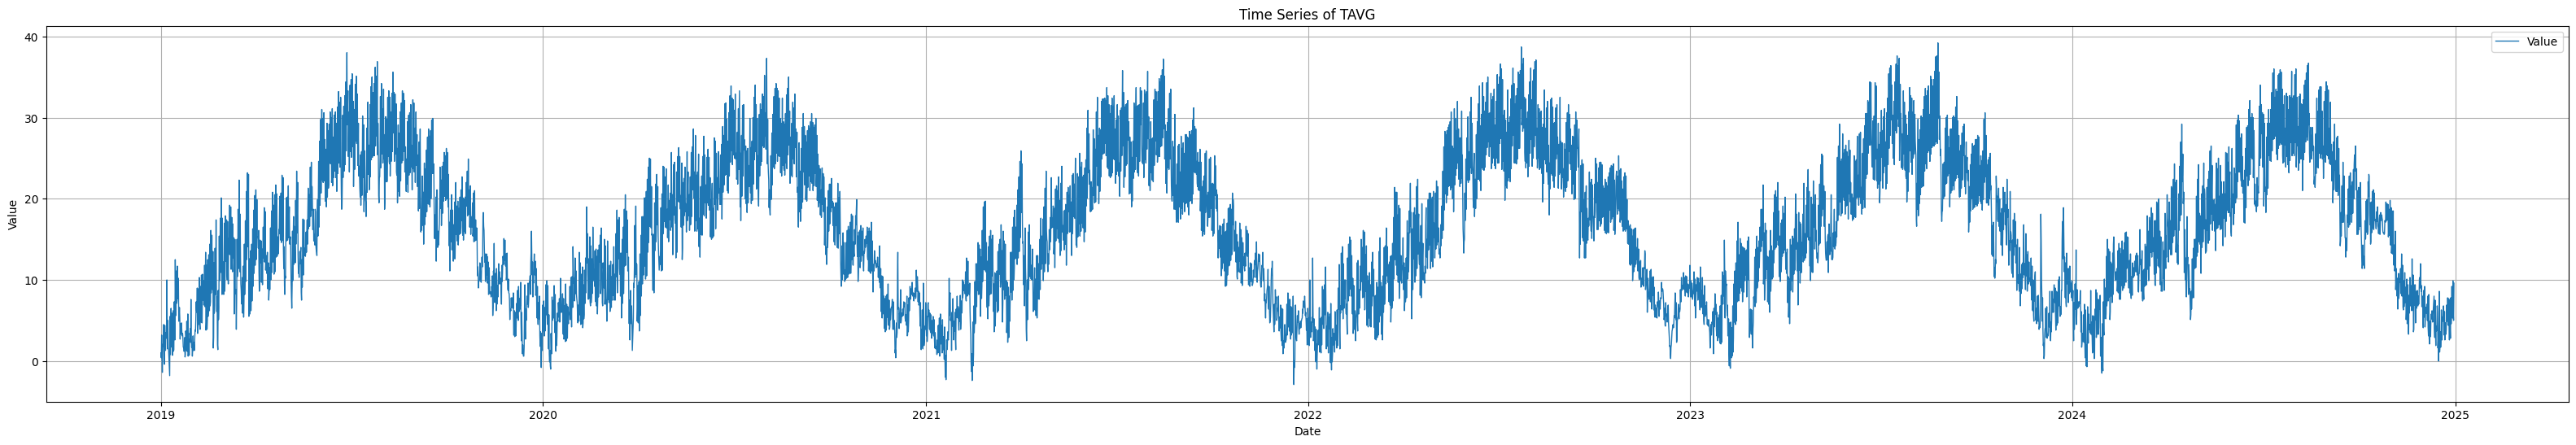

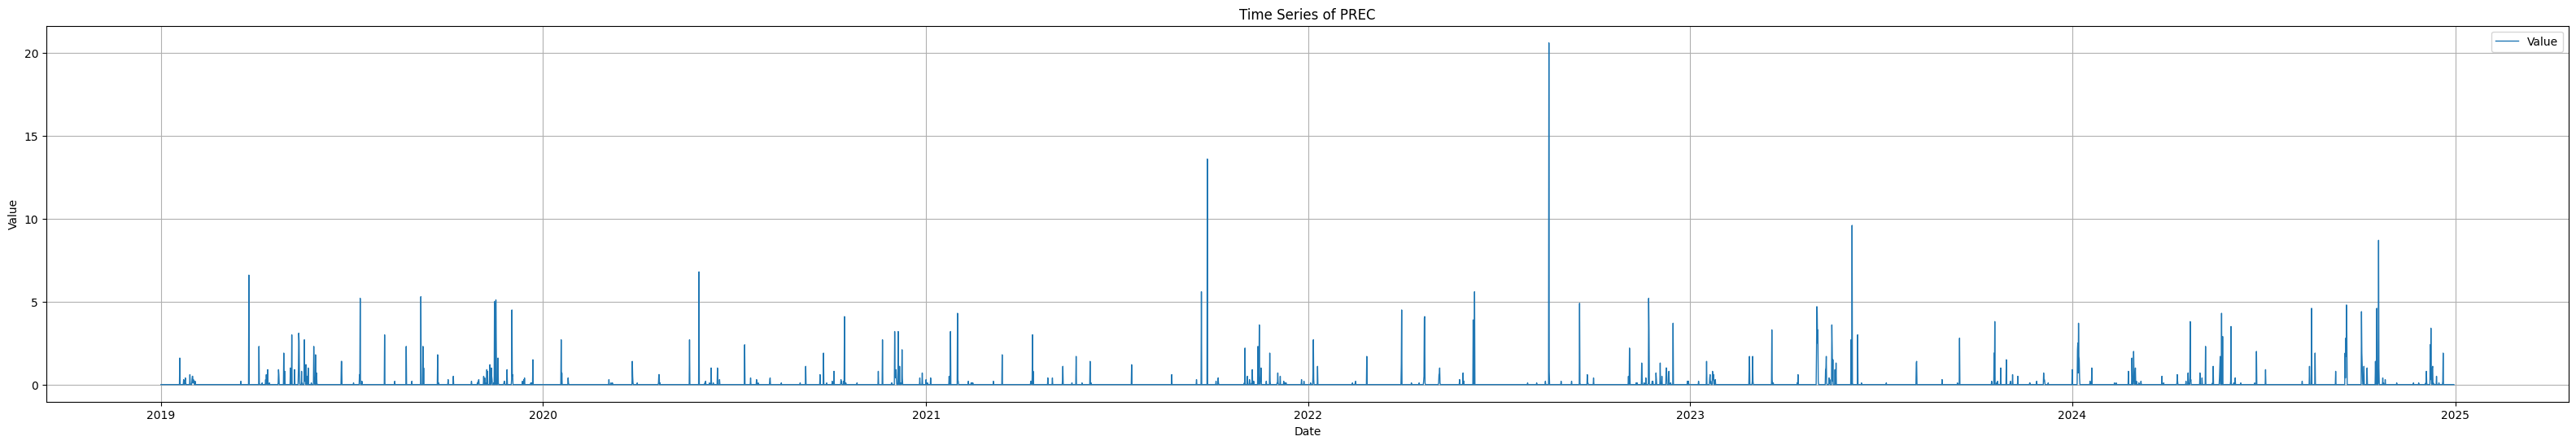

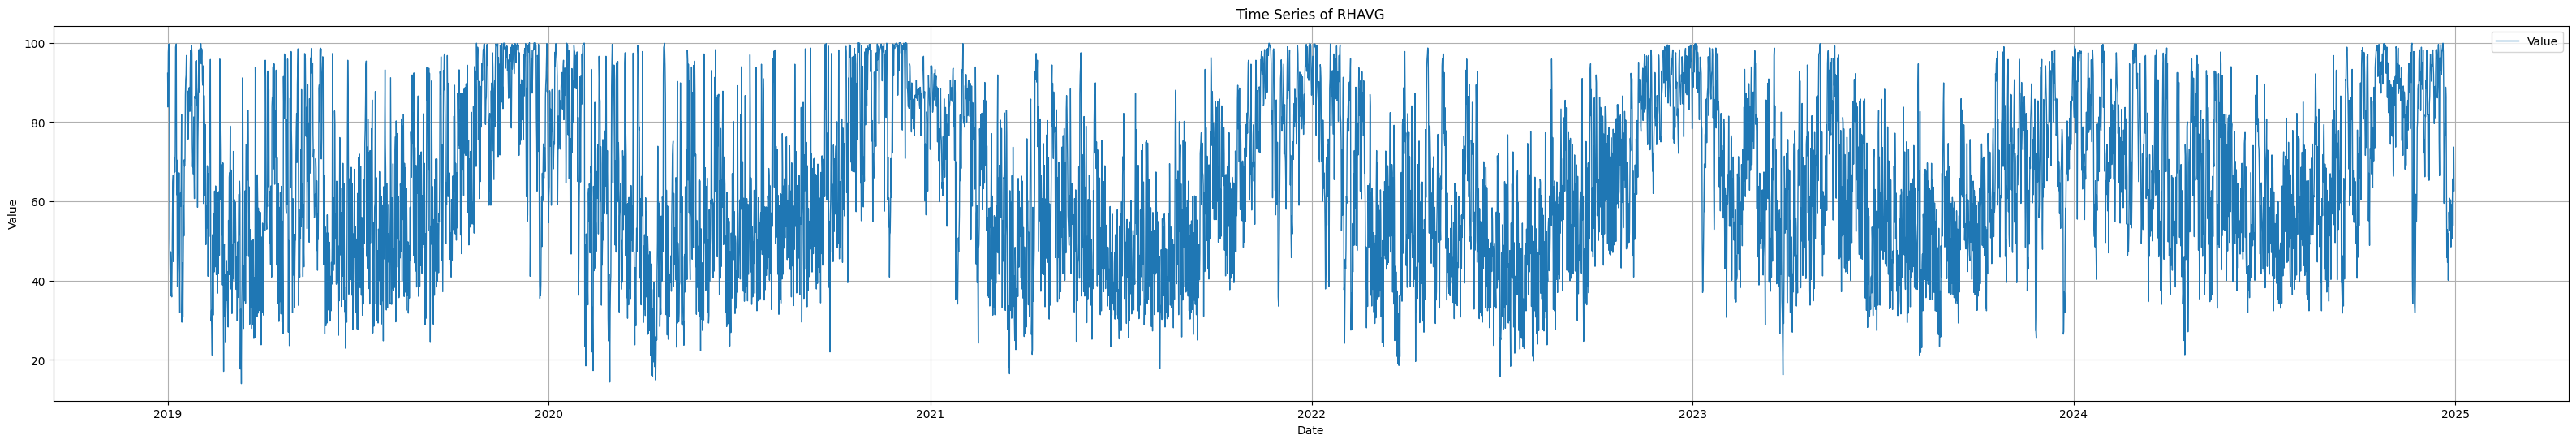

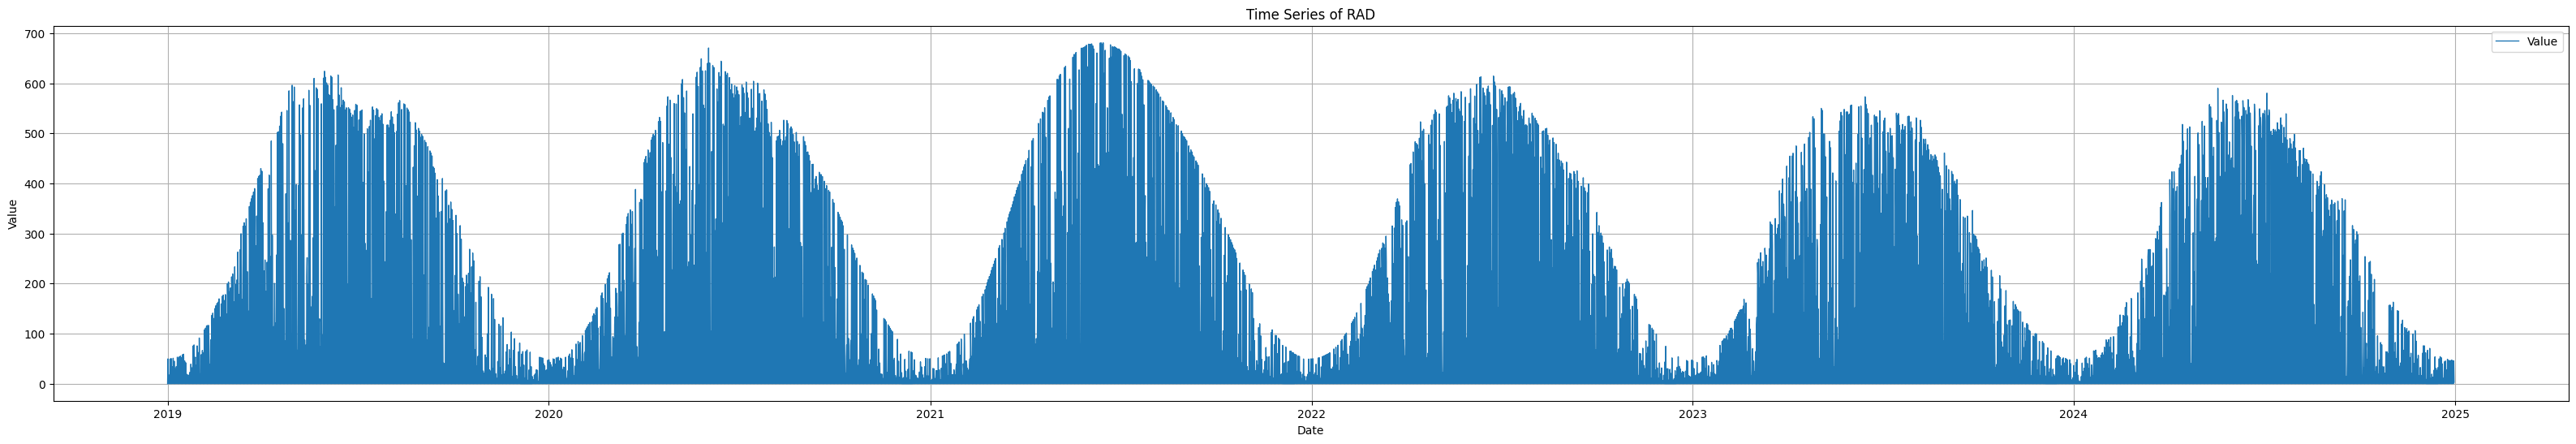

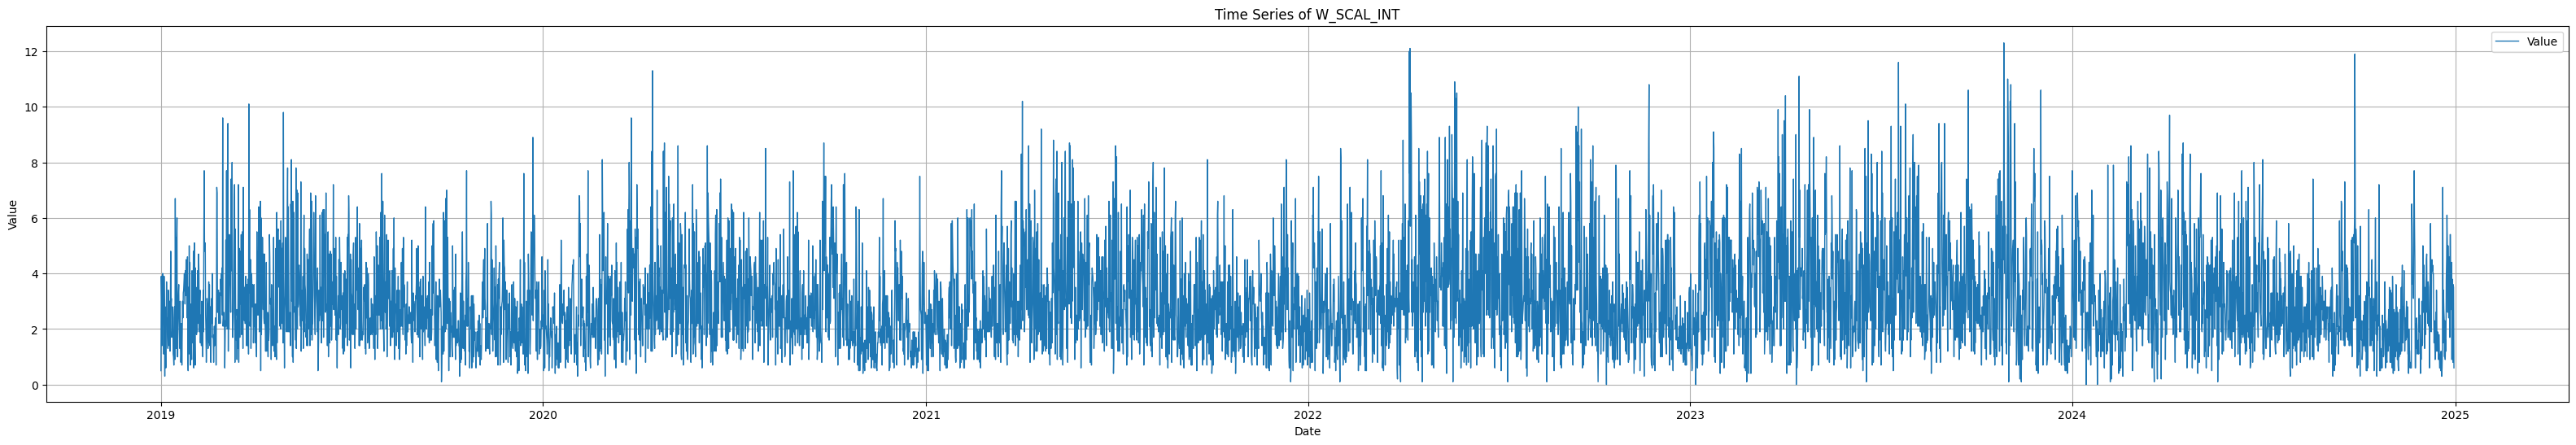

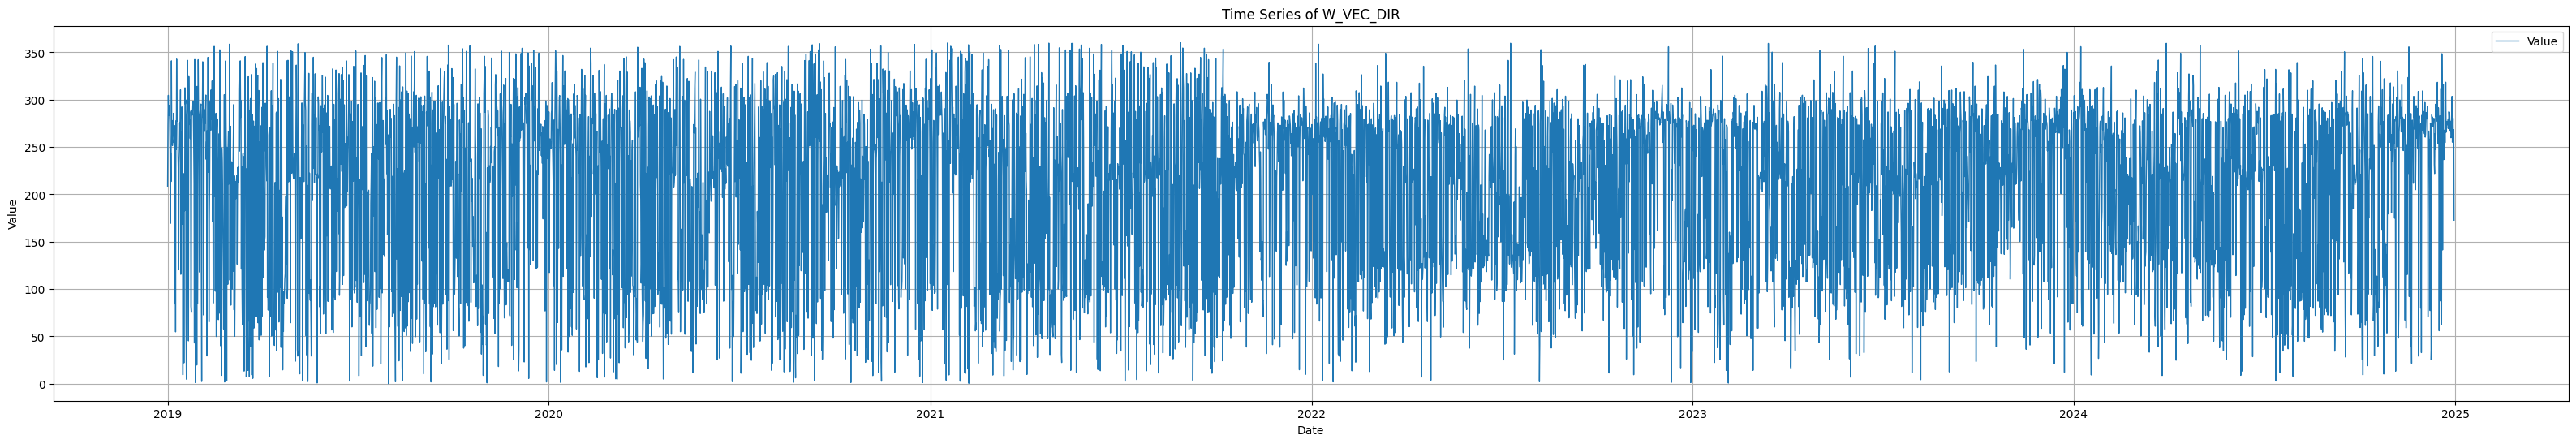

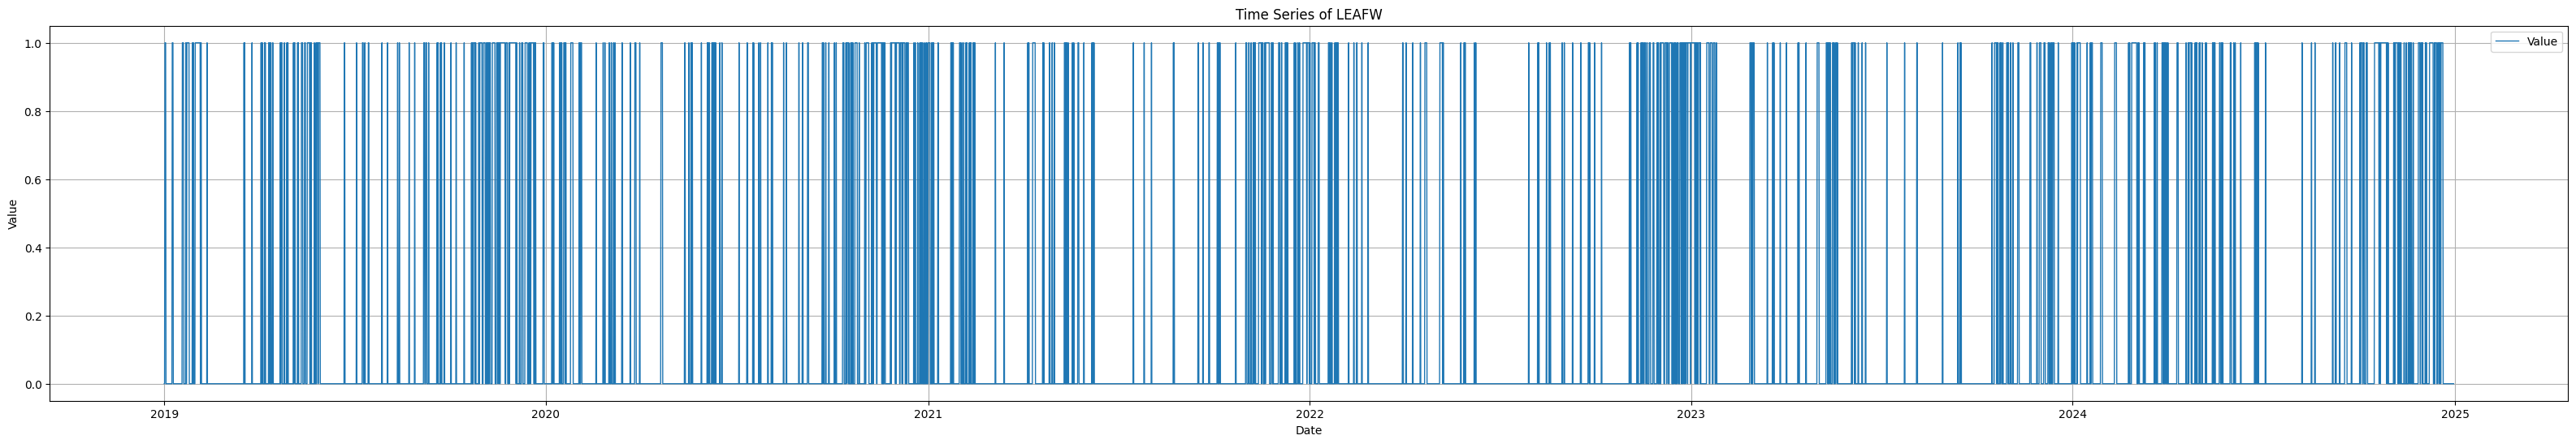

In [6]:
weather_df.sort_index(inplace=True)
for feature in weather_df.columns:
    if feature != 'Date':
        plot_time_series([weather_df], feature, None,['Value'], datetime(2019, 1, 1), datetime(2024, 12, 31), title=feature)

We notice that some of the features present a clear periodicity (temperature, humidity, radiance). Leaf wetness is a binary feature.

## **Daily Aggregation**

When trying to consider a daily representation, the weather, and traffic dataframe, should be aggregated with the right approach to correctly represent the 24 values of the day. For part of the features, a simple sum or average is not meaningful.

The features of the weather dataset can be aggregated as follows:
- Average Temperature (TAVG):
    - a Since it is an average already, we can average the values one more time
    - or we can split the feature into maximum and minimum value of the day
- Precipitation (PREC):
    - total sum of precipitations
- Average Relative Humidity (RHAVG):
    - like for average temperature, we can average the values
    - or split into max and min
- Solar Radiation (RAD):
    - sum of the total solar radiation
- Scalar Wind Intensity (W_SCAL_INT):
    - average intensity value
- Vector Wind Direction (W_VEC_DIR):
    - average vector direction
- Leaf Wetness (LEAFW):
    - count the number of hours where the leafs are wet

Let's apply the reasoning to one day of data:

In [7]:
start = datetime(2019,1,1)
end = datetime(2019,1,2)

one_day_df = weather_df[(weather_df.index>=start)&(weather_df.index<end)]
one_day_df

TAVG  PREC  RHAVG    RAD  W_SCAL_INT  W_VEC_DIR  LEAFW
Date                                                                       
2019-01-01 00:00:00   1.0   0.0   92.3    0.0         0.5      208.7    0.0
2019-01-01 01:00:00   0.3   0.0   93.6    0.0         0.5      280.0    0.0
2019-01-01 02:00:00   0.7   0.0   91.7    0.0         1.1      158.1    0.0
2019-01-01 03:00:00   0.4   0.0   91.5    0.0         0.7      189.4    0.0
2019-01-01 04:00:00   1.0   0.0   86.3    0.0         0.7      172.9    0.0
2019-01-01 05:00:00   2.3   0.0   79.7    0.0         1.8      151.0    0.0
2019-01-01 06:00:00  -0.2   0.0   85.3    0.0         1.8      338.7    0.0
2019-01-01 07:00:00  -0.1   0.0   86.6    0.0         2.1      297.5    0.0
2019-01-01 08:00:00   0.4   0.0   83.8   49.7         3.9      272.4    0.0
2019-01-01 09:00:00   1.5   0.0   81.4  165.7         3.5      276.2    0.0
2019-01-01 10:00:00   2.0   0.0   81.8  260.6         3.1      287.5    1.0
2019-01-01 11:00:00   3.4   0.0   84.6  299.8         3.1      287.0    0.0
2019-01-01 12:00:00   3.7   0.0   87.3  277.3         3.0      305.5    0.0
2019-01-01 13:00:00   3.7   0.0   93.1  273.5         2.8      304.4    0.0
2019-01-01 14:00:00   3.5   0.0   95.4  147.2         3.6      287.9    1.0
2019-01-01 15:00:00   3.6   0.0   95.5   80.2         4.0      257.0    1.0
2019-01-01 16:00:00   3.2   0.0   97.6    6.5         3.1      304.6    1.0
2019-01-01 17:00:00   3.1   0.0   95.4    0.0         2.8      297.6    1.0
2019-01-01 18:00:00   2.6   0.0   98.6    0.0         3.2      296.7    1.0
2019-01-01 19:00:00   2.1   0.0   99.1    0.0         3.3      278.5    1.0
2019-01-01 20:00:00   2.5   0.0   96.0    0.0         3.5      267.0    1.0
2019-01-01 21:00:00   3.1   0.0   89.4    0.0         2.8      261.2    0.0
2019-01-01 22:00:00   2.8   0.0   88.9    0.0         2.1      289.4    0.0
2019-01-01 23:00:00   1.5   0.0   94.5    0.0         2.0      312.0    1.0

The transformation can be applied with the utility function as follows:

In [12]:
aggregations = { # for omitted columns default aggregation is the mean
    'W_SCAL_INT': 'mean',
    'PREC': 'sum',
    'RAD': 'sum',
    'W_VEC_DIR': mean_vector_direction,
    'LEAFW': lambda x: (x > 0).sum()
}

max_min_columns = ['TAVG', 'RHAVG']

transform_weather_to_daily_df(
    one_day_df,
    aggregations=aggregations,
    max_min_columns = max_min_columns,
    keep_splitted_columns=True # if a column is split, also keep it along with average aggregation
)

TAVG  PREC      RHAVG     RAD  W_SCAL_INT   W_VEC_DIR  LEAFW  \
Date                                                                           
2019-01-01  2.004167   0.0  90.391667  1560.5    2.458333  274.482833      9   

            TAVG_MAX  TAVG_MIN  RHAVG_MAX  RHAVG_MIN  
Date                                                  
2019-01-01       3.7      -0.2       99.1       79.7

In [13]:
aggregated_df = transform_weather_to_daily_df(weather_df,
    aggregations=aggregations,
    max_min_columns = max_min_columns,
    keep_splitted_columns=True # if a column is split, also keep it along with average aggregation
)

## **Aggregated Data Visualization**

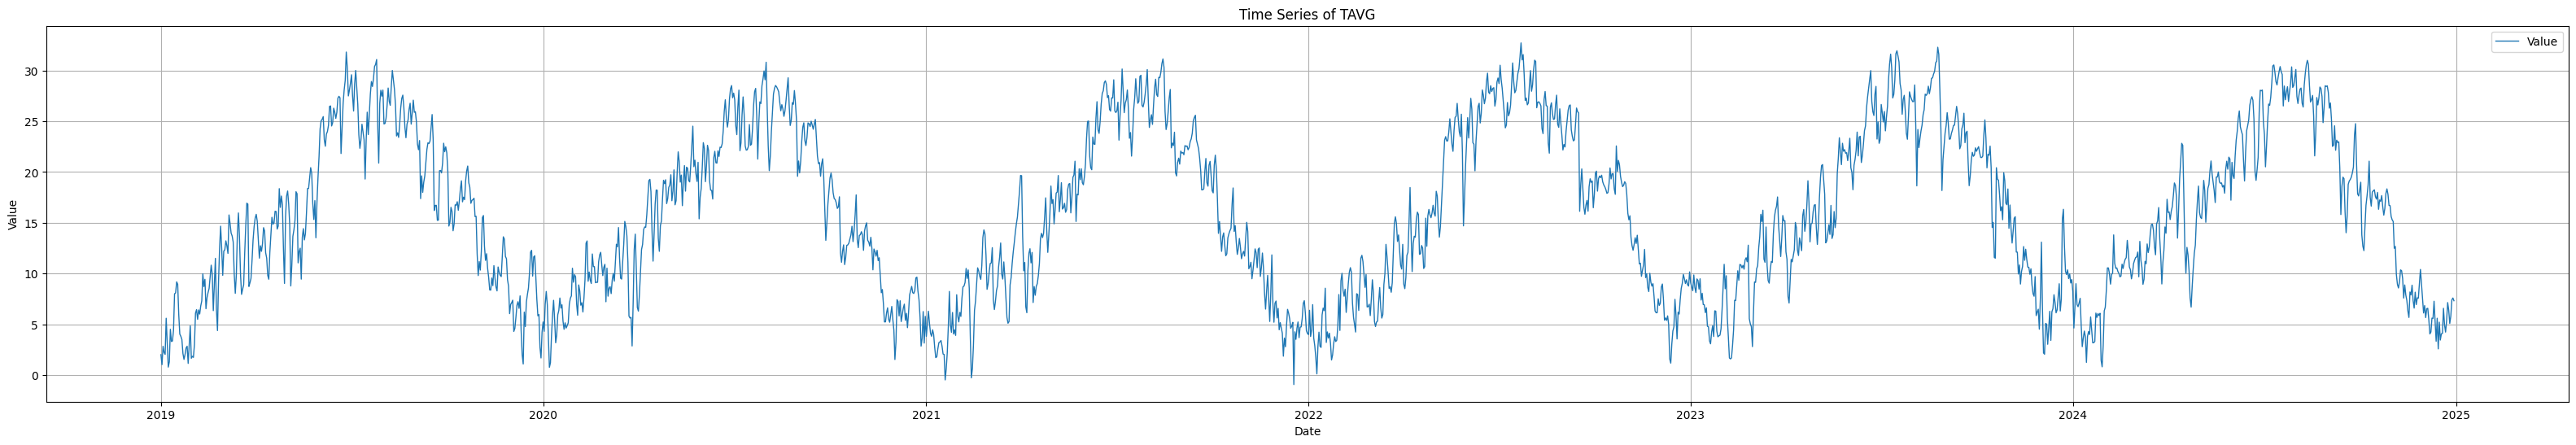

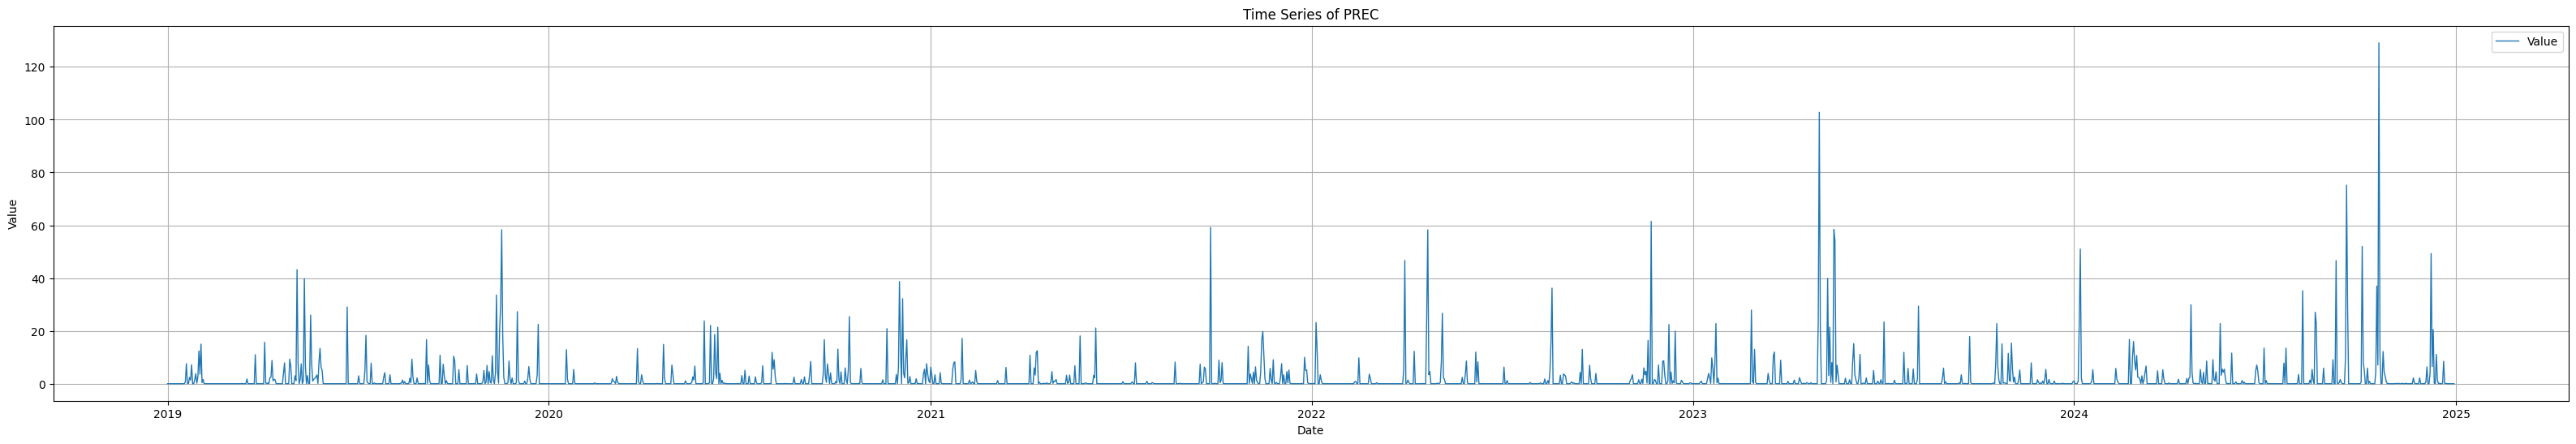

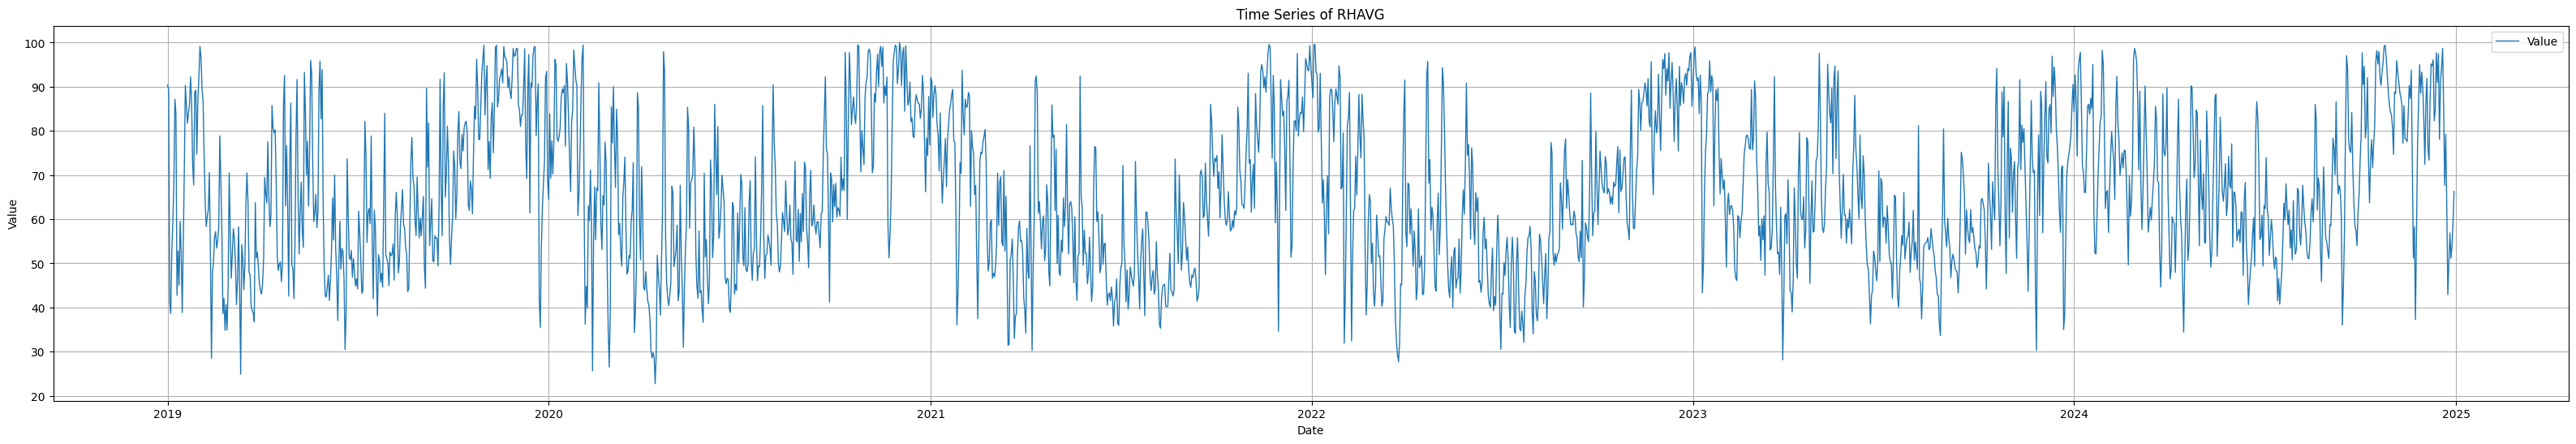

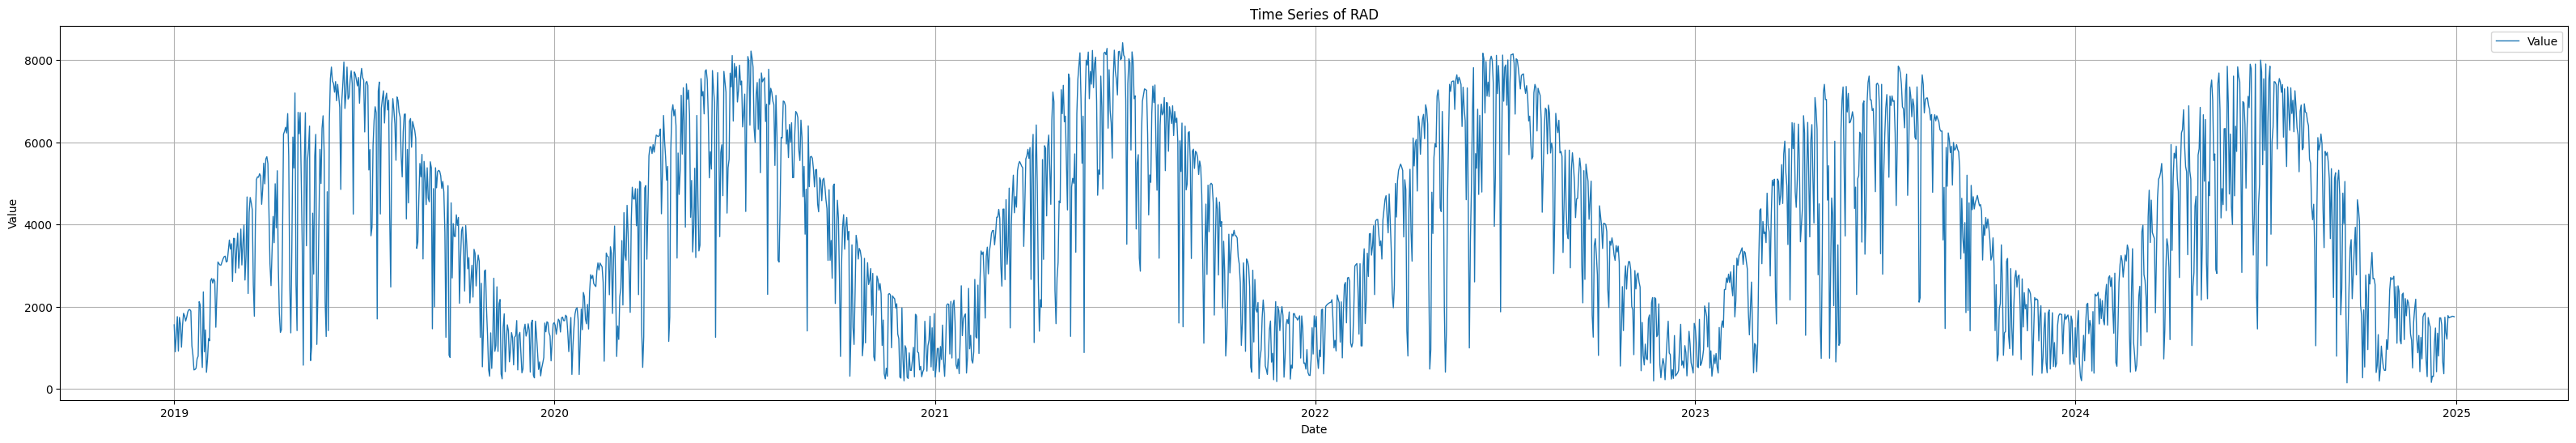

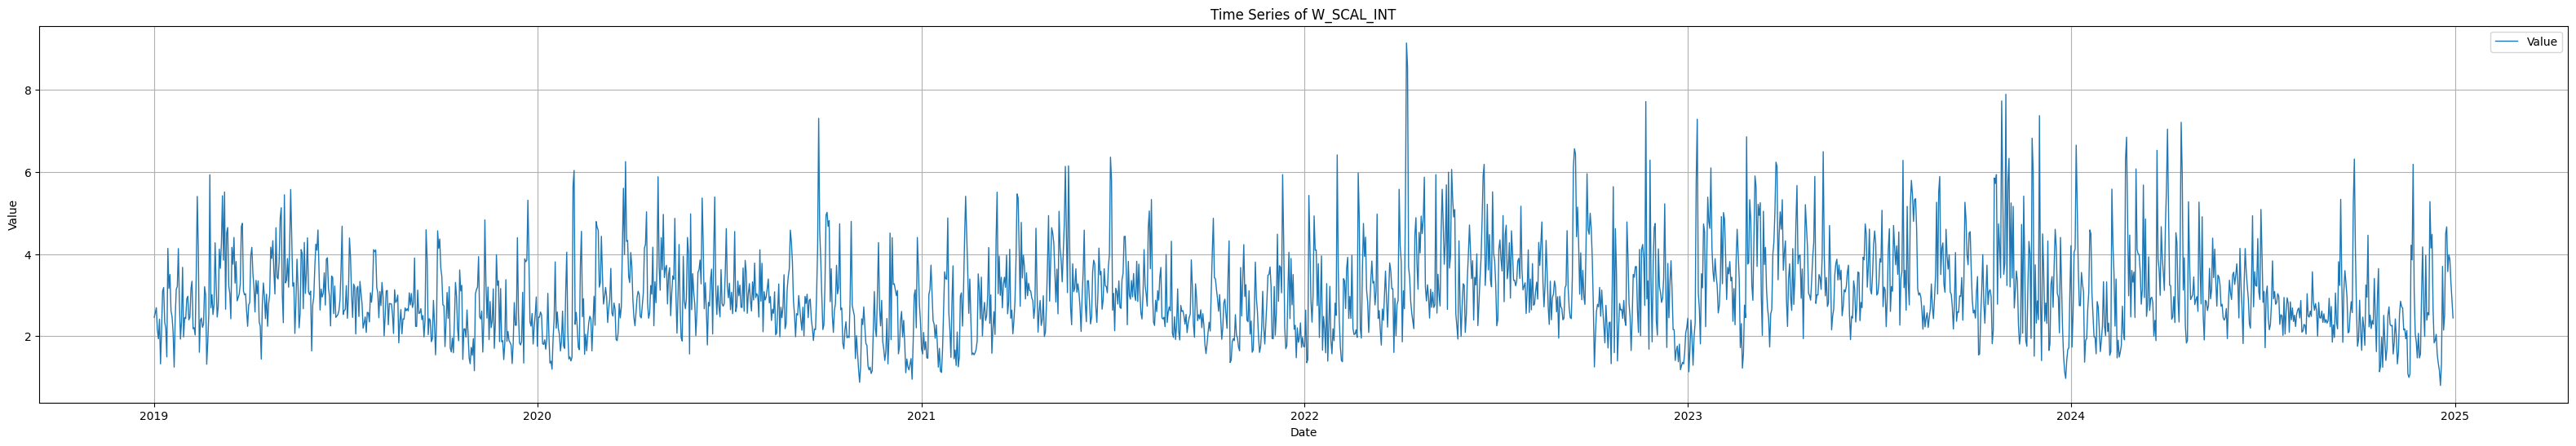

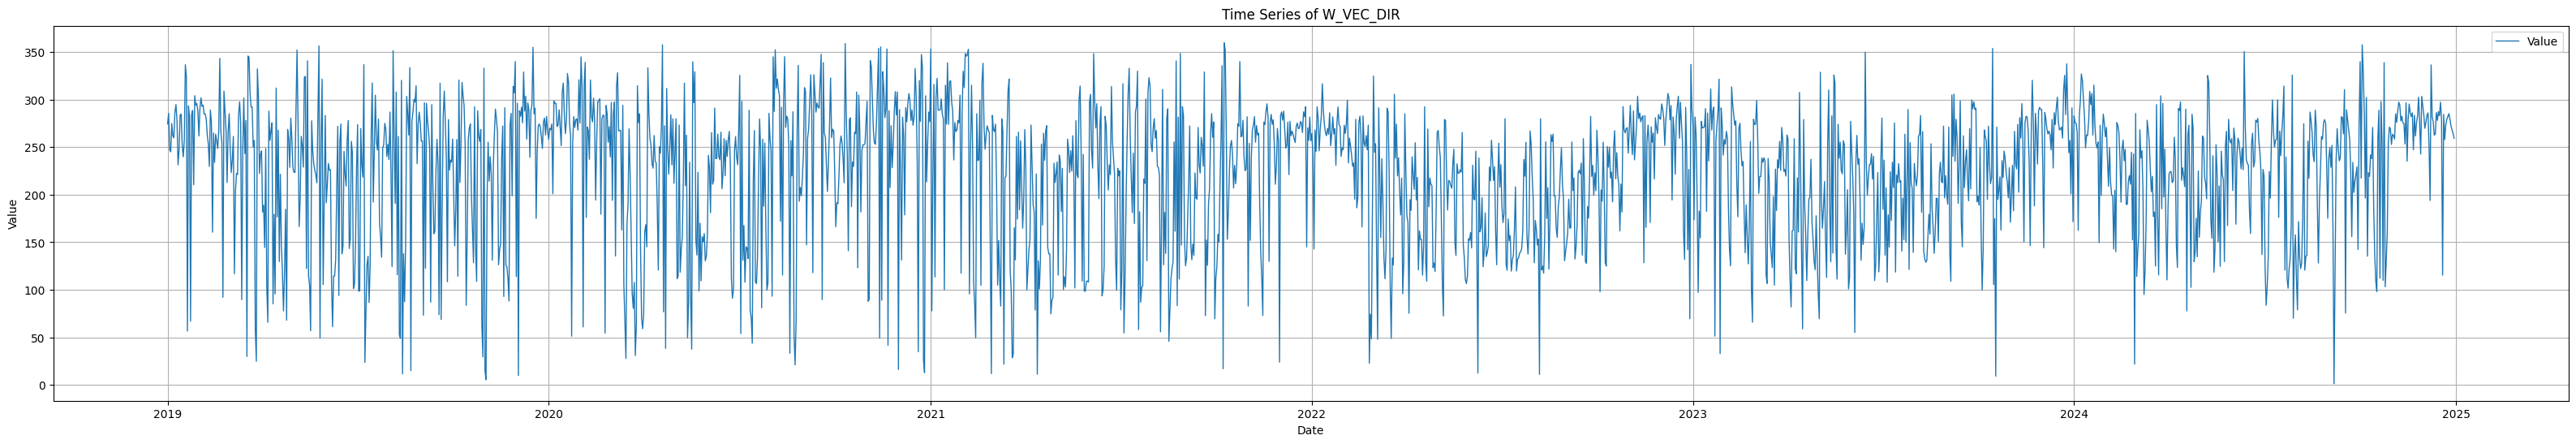

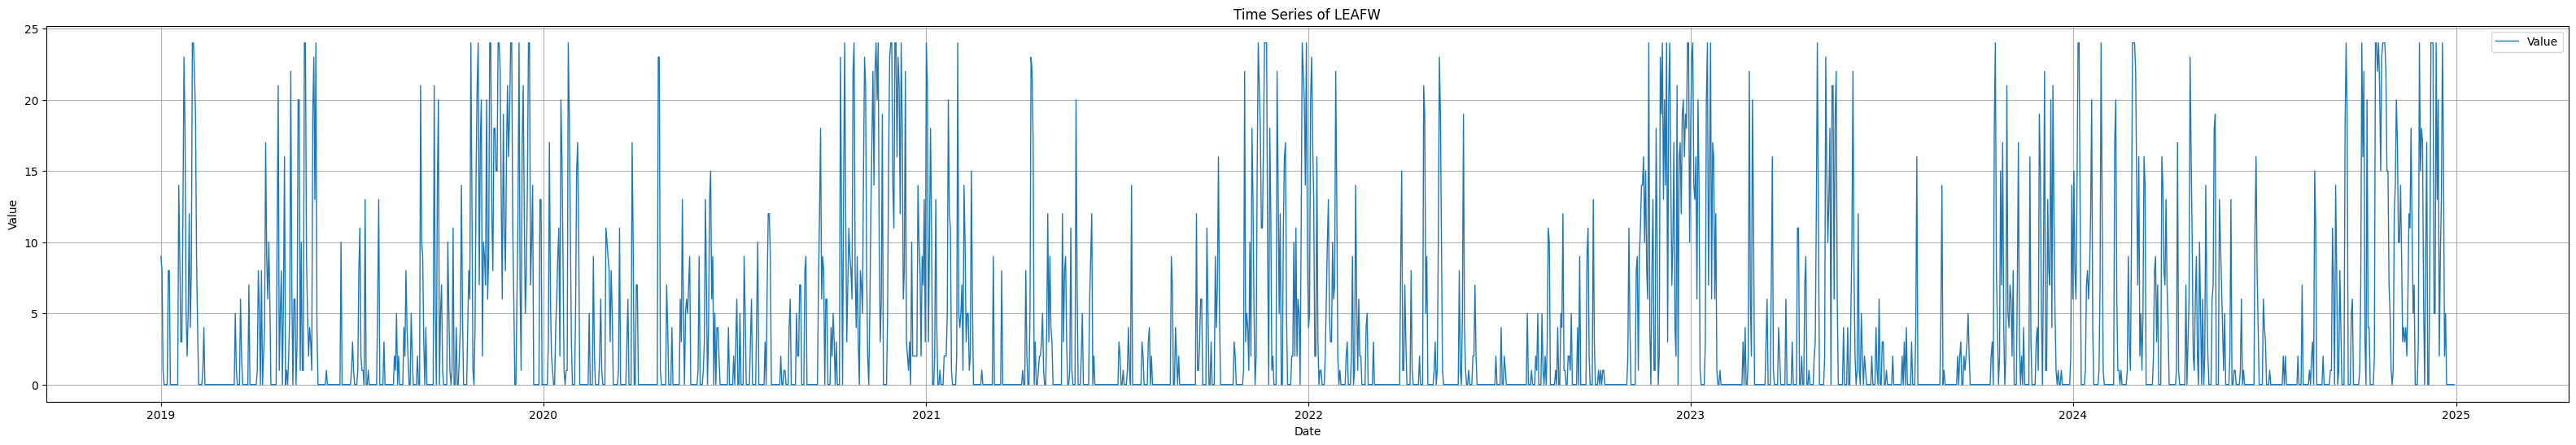

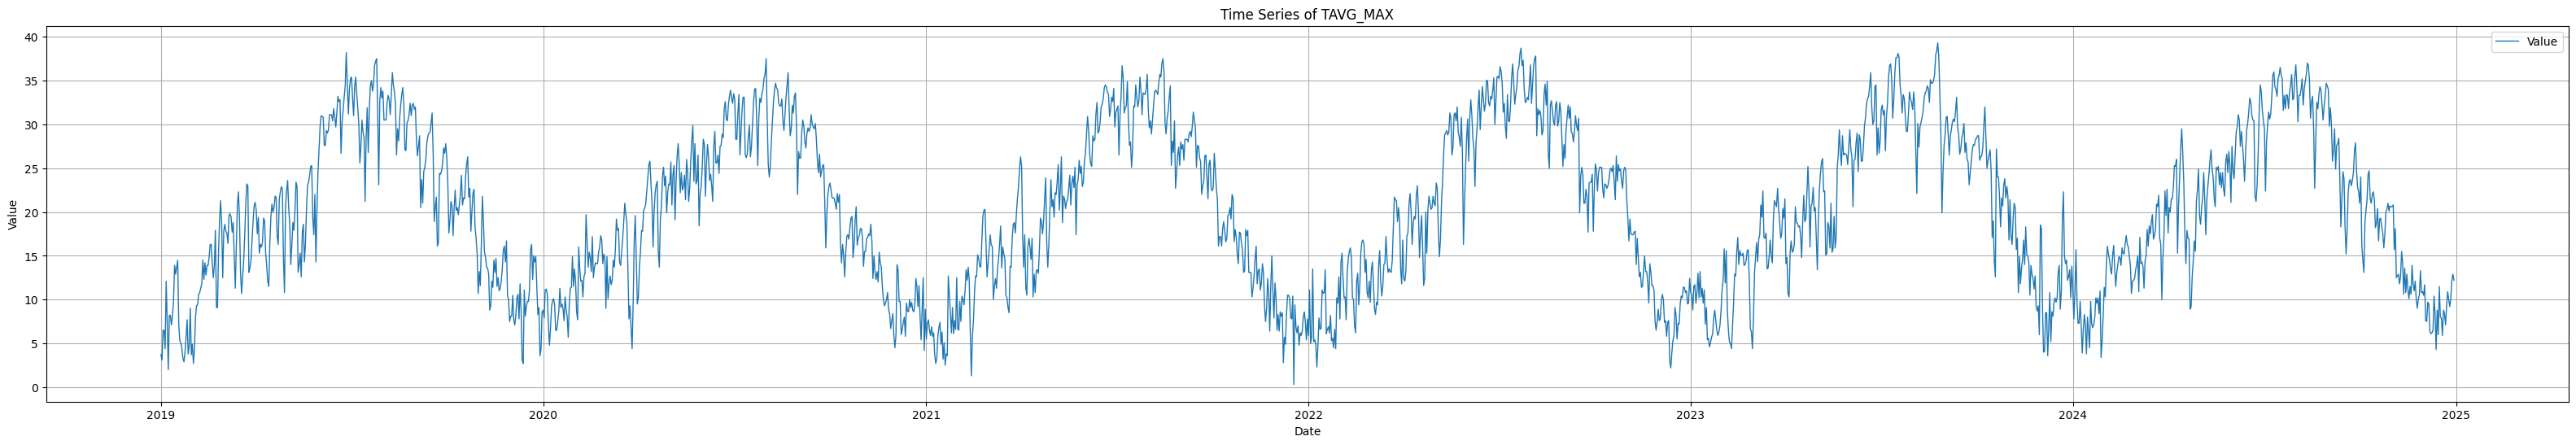

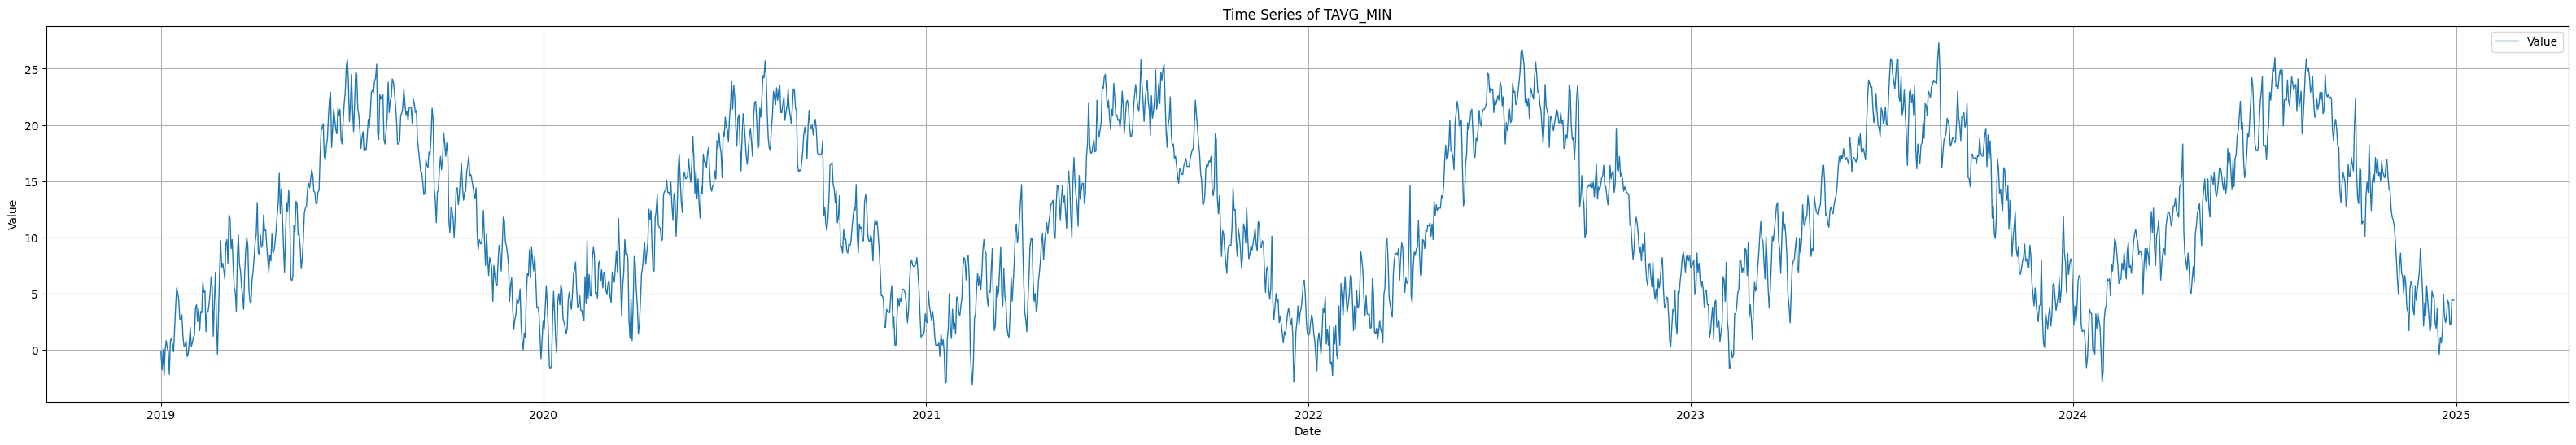

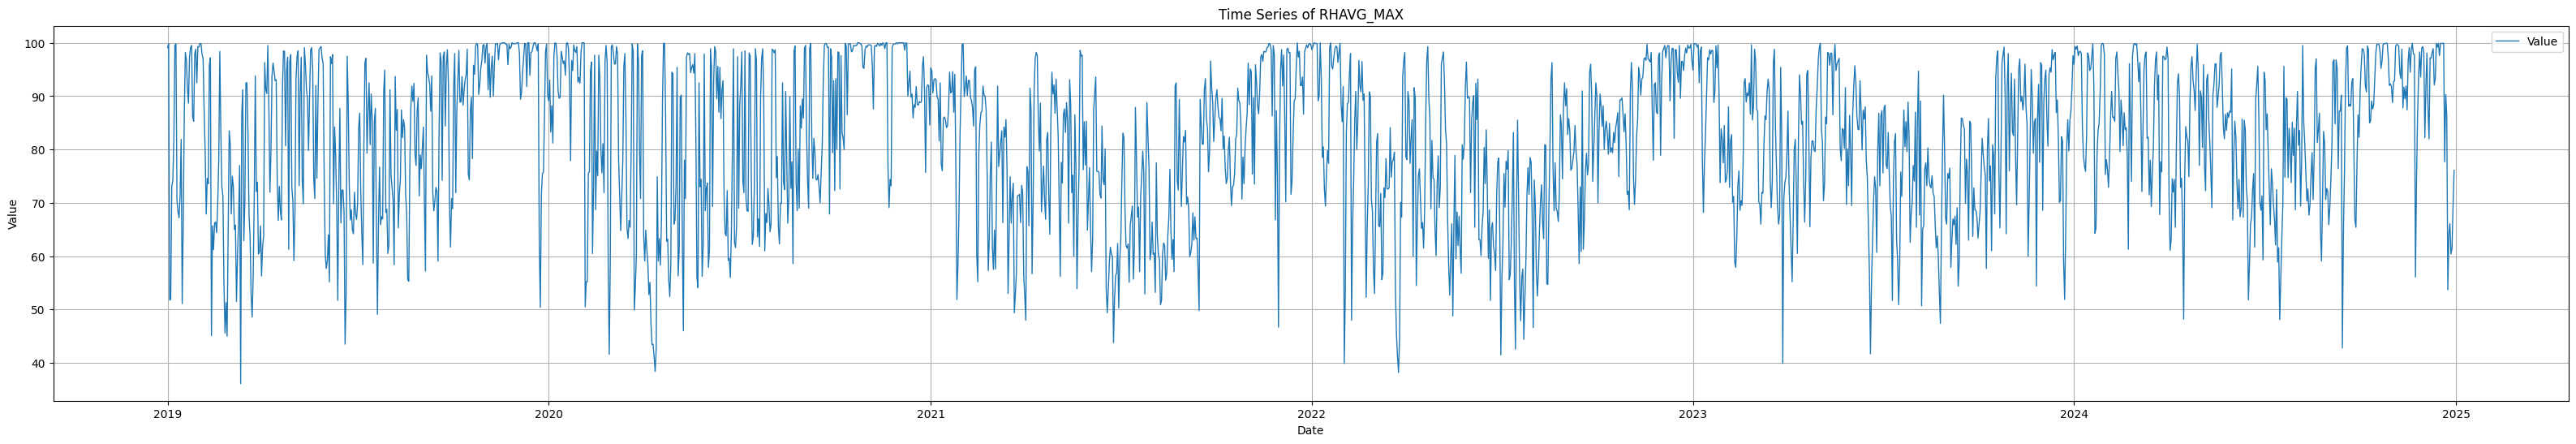

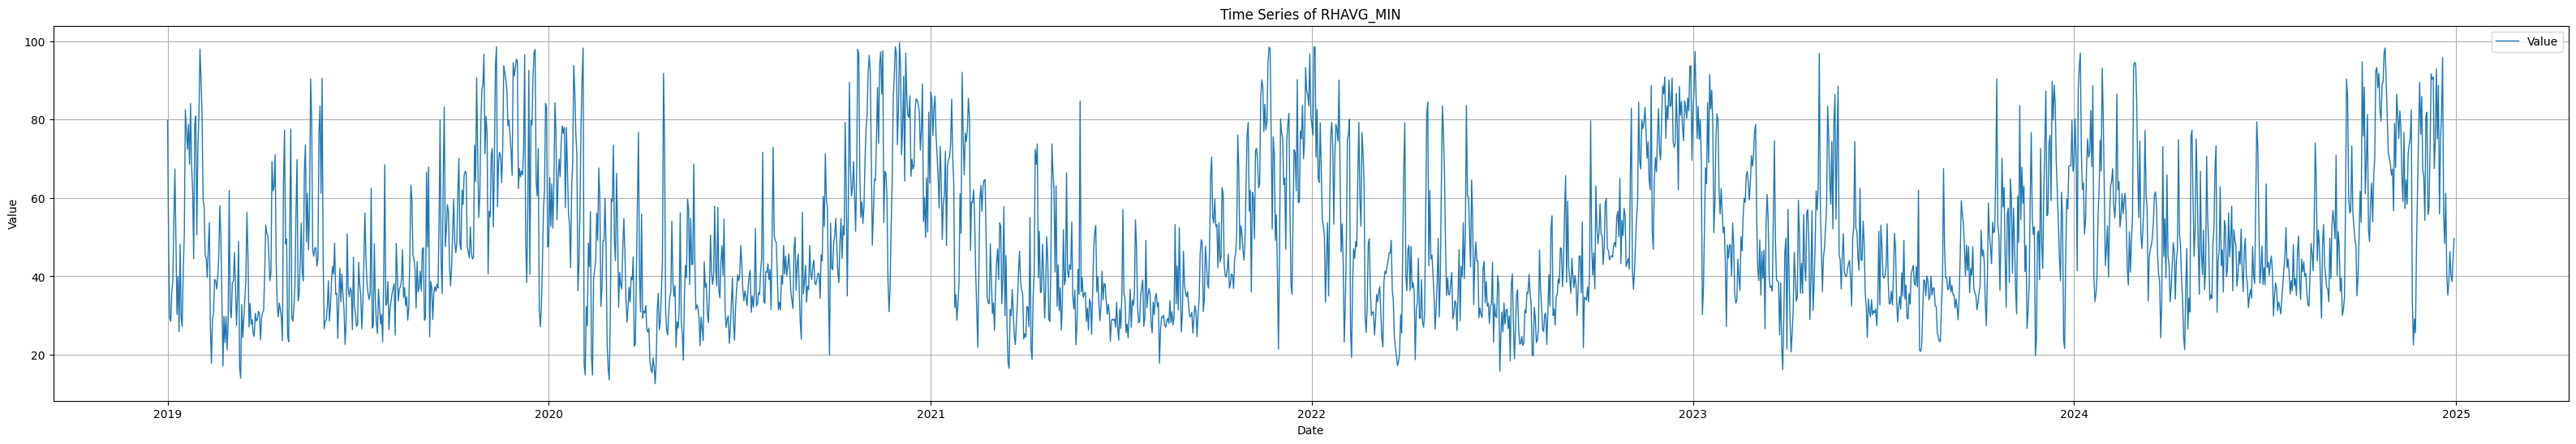

In [14]:
aggregated_df.sort_index(inplace=True)
for feature in aggregated_df.columns:
    if feature != 'Date':
        plot_time_series([aggregated_df], feature, None,['Value'], datetime(2019, 1, 1), datetime(2024, 12, 31), title=feature)

We can see that the periodicity is mantained also after the daily aggregation.